In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm


from sklearn.metrics import  roc_auc_score

import xgboost as xgb

%matplotlib inline

In [2]:
#get directory
df_train_path = os.path.join('/content/drive/MyDrive/data','df_train_scaled.csv')
df_test_path = os.path.join('/content/drive/MyDrive/data','df_test_scaled.csv')

In [3]:
df_train = pd.read_csv(df_train_path, compression='zip',index_col=0)
df_train.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.608872,0.164693,-0.163457,-0.325463,1.122052,0.447071,-0.429185,-1.307963,0,-0.284092,-1.473992,0,-0.546784,-1.023435,-0.312566,0,-0.507738,0.163442,-1.289327,-0.664438,0.751798
67,1.642269,1.571844,-1.681827,-1.852288,-1.097898,2.003534,0.922524,-1.307963,1,-1.129831,0.315839,0,0.051569,1.656392,0.185487,0,1.811497,-0.290346,0.013519,-1.142713,-0.953725
109,-0.608872,0.164693,-0.163457,-0.325463,-1.097898,-1.109391,0.373296,1.107810,0,-0.284092,0.504437,0,-0.039984,1.171393,-0.810619,0,-0.405765,-0.661155,-1.119129,-0.505013,0.751305
166,-0.608872,0.045809,-0.163457,-0.172780,-1.375392,-1.109391,-1.966736,1.107810,0,-0.284092,1.057904,0,-0.491274,-0.982334,-0.810619,0,-1.030678,0.453866,-0.581365,0.451536,0.690353
240,-0.608872,0.350584,-0.163457,-0.478145,-1.097898,-1.109391,-0.044315,1.107810,0,-0.706962,1.628628,0,-0.101400,0.123301,-0.810619,0,0.015201,-0.203410,-1.206653,-0.823863,0.847883


In [4]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)



In [5]:
df_test = pd.read_csv(df_test_path, compression='zip',index_col=0)
df_test.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.570708,-1.292197,1.358839,1.211831,0.854755,-0.987969,-0.548759,1.121379,0,1.506498,-2.105183,0,-0.837022,-2.334517,0.974724,0,0.604761,-1.478367,-1.421052,2.231901,-0.038992
78,-0.570708,-0.277482,0.593949,0.285325,1.130541,0.689838,-0.196528,-1.307721,0,2.828003,1.653735,0,0.907334,0.472810,0.527530,0,0.558767,-0.287923,-0.493957,0.551974,0.480381
83,-0.570708,-0.835138,0.593949,0.902995,1.130541,0.689838,1.286175,1.121379,0,-0.255508,-1.113280,0,0.232658,-0.556269,0.974724,0,0.943588,0.338626,0.869687,0.887959,0.192246
123,-0.570708,2.322725,-1.700719,-1.567686,1.130541,-0.987969,0.760771,-1.307721,0,-0.255508,-0.489658,1,-0.660958,-0.350453,0.080337,1,0.313079,-1.384385,-1.711448,-0.959961,1.905790
144,1.752125,-0.277482,0.593949,0.285325,-0.524176,0.689838,-0.262192,-1.307721,1,0.625495,0.779682,0,-0.559868,-1.540069,0.080337,0,-0.176380,0.338626,0.799203,2.231901,-2.143249


In [6]:
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].values
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_test =X_test.drop(columns=drop_columns)

In [7]:
X_train=X_train.values

In [8]:
y_train=y_train.values

In [9]:
X_test=X_test.values

In [10]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
auc_arr = []

for _ in tqdm(range(25)):
    idx = np.random.choice(np.arange(len(X_train)), 500_000, replace=True)
    X_temp = X_train[idx]
    y_temp = y_train[idx]
    
    #instantiate classifier
    clf = xgb.XGBClassifier(colsample_bytree=0.9, eta=0.05, max_depth=6,n_estimators=200,
                              n_jobs=-1, scale_pos_weight=estimate)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    y_pred = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred[:,1])
    auc_arr.append(score)

  0%|          | 0/25 [00:00<?, ?it/s]

Estimate: 3.973


100%|██████████| 25/25 [12:05<00:00, 29.03s/it]


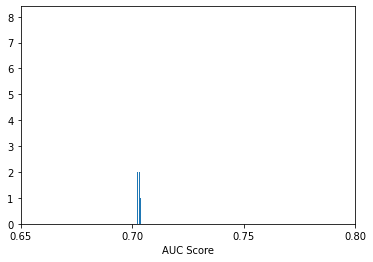

In [12]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.65, 0.8, 0.05))
plt.savefig(os.path.join("/content/drive/MyDrive/plots", 'auc_632_sampling.png'))
plt.show()